In [7]:
# Install system dependencies
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig > /dev/null 2>&1
!apt install xvfb -y > /dev/null 2>&1

# Install Python packages
!pip install gymnasium[classic_control] --quiet
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!pip install ipycanvas > /dev/null 2>&1

# Setup a virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces

class PartiallyObservableGridEnv(gym.Env):
    def __init__(self, size=5, observation_size=3):
        super().__init__()
        self.size = size
        self.observation_size = observation_size
        self.agent_pos = None
        self.goal_pos = (size - 1, size - 1)
        self.action_space = spaces.Discrete(4) # 0: up, 1: right, 2: down, 3: left

        # The observation space is a local grid (e.g., 3x3)
        self.observation_space = spaces.Box(low=0, high=1, shape=(observation_size, observation_size), dtype=int)

        self.grid = self._create_grid()

    def _create_grid(self):
        grid = np.zeros((self.size, self.size), dtype=int)
        # 0: empty, 1: wall (optional for complexity), 2: agent, 3: goal
        grid[self.goal_pos] = 3
        return grid

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Place the agent randomly but not on the goal
        while True:
            self.agent_pos = tuple(self.np_random.integers(0, self.size, size=2))
            if self.agent_pos != self.goal_pos:
                break

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def _get_obs(self):
        # Extract a local window (e.g., 3x3) around the agent
        # Pad the grid to handle boundaries
        padded_grid = np.pad(self.grid, self.observation_size // 2, mode='constant', constant_values=0)

        # Calculate the top-left corner of the observation window
        r, c = self.agent_pos
        start_r = r + self.observation_size // 2 - self.observation_size // 2
        start_c = c + self.observation_size // 2 - self.observation_size // 2

        # Ensure the observation window is correctly positioned around the agent
        obs_window = padded_grid[start_r : start_r + self.observation_size,
                                 start_c : start_c + self.observation_size].copy()

        # Update the agent's position in the observation for visual clarity
        obs_window[self.observation_size // 2, self.observation_size // 2] = 2 # Agent

        return obs_window

    def _get_info(self):
        return {"agent_location": self.agent_pos, "goal_location": self.goal_pos}

    def step(self, action):
        # Map the action to a new position
        r, c = self.agent_pos
        if action == 0: r -= 1 # Up
        elif action == 1: c += 1 # Right
        elif action == 2: r += 1 # Down
        elif action == 3: c -= 1 # Left

        # Check for boundaries (simple, agent stops at edge)
        r = np.clip(r, 0, self.size - 1)
        c = np.clip(c, 0, self.size - 1)

        self.agent_pos = (r, c)

        # Check if goal reached
        terminated = (self.agent_pos == self.goal_pos)
        reward = 1.0 if terminated else 0.0

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, False, info # terminated, truncated, info

    def render(self, mode='human'):
        # We will use matplotlib to render the observation grid directly in Colab
        return self._render_frame()

    def _render_frame(self):
        # Create a simple visual representation of the observation
        data = self._get_obs()

        plt.imshow(data, cmap='viridis', extent=[0, self.observation_size, 0, self.observation_size])
        plt.xticks(np.arange(self.observation_size + 1))
        plt.yticks(np.arange(self.observation_size + 1))
        plt.grid(True)
        plt.show()



In [9]:
from gymnasium import spaces
import numpy as np

class PartiallyObservableGridWorldEnv(gym.Env):
    def __init__(self, size=5):
        super().__init__()
        self.size = size
        self._agent_location = None
        self._target_location = None

        # Actions: 0: right, 1: up, 2: left, 3: down
        self.action_space = spaces.Discrete(4)

        # Observation space: a 3x3 grid centered on the agent (vision field)
        # Values can represent: 0: empty, 1: agent, 2: wall/obstacle (if any), 3: target
        self.observation_space = spaces.Box(low=0, high=3, shape=(3, 3), dtype=int)

        self._action_to_direction = {
            0: np.array([0, 1]), 1: np.array([-1, 0]),
            2: np.array([0, -1]), 3: np.array([1, 0])
        }

    def _get_obs(self):
        # Create an empty 3x3 observation
        obs = np.zeros((3, 3), dtype=int)

        # Define the agent's surrounding area
        r_start = self._agent_location[0] - 1
        c_start = self._agent_location[1] - 1

        for i in range(3):
            for j in range(3):
                r, c = r_start + i, c_start + j
                if 0 <= r < self.size and 0 <= c < self.size:
                    if np.array_equal([r, c], self._agent_location):
                        obs[i, j] = 1 # Agent
                    elif np.array_equal([r, c], self._target_location):
                        obs[i, j] = 3 # Target
                    # You could add logic for obstacles here
                # else: obs[i, j] remains 0 (or could be set to a "wall" value)
        return obs

    def _get_info(self):
        # Optional diagnostic info
        return {"distance_to_target": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Place agent and target randomly, ensuring they are not in the same spot
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        direction = self._action_to_direction[action]
        # Calculate new location and clip to bounds
        new_location = np.clip(self._agent_location + direction, 0, self.size - 1)
        self._agent_location = new_location

        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1.0 if terminated else 0.0 # Basic reward
        observation = self._get_obs()
        info = self._get_info()
        truncated = False # No time limit for this example

        return observation, reward, terminated, truncated, info

    def render(self):
        # Use matplotlib to create a visual representation for Colab
        grid = np.zeros((self.size, self.size, 3), dtype=np.uint8) # RGB
        grid[self._agent_location[0], self._agent_location[1]] = [0, 0, 255] # Agent as Blue
        grid[self._target_location[0], self._target_location[1]] = [0, 255, 0] # Target as Green

        # Display the grid in Colab
        plt.imshow(grid, origin='lower')
        plt.axis('off')
        plt.show()


Initial Observation:


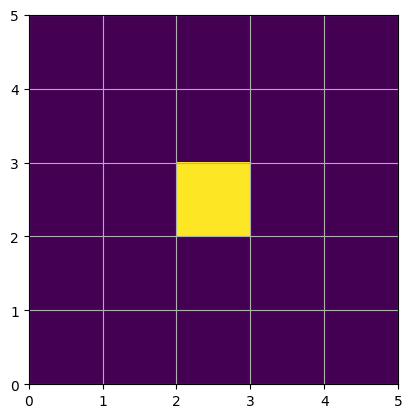


Action taken: Right
Agent Location: (np.int64(0), np.int64(9)), Reward: 0.0, Done: False


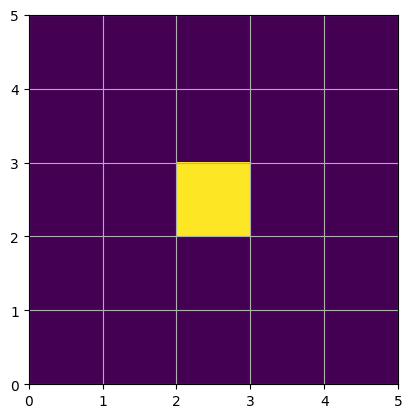


Action taken: Right
Agent Location: (np.int64(0), np.int64(9)), Reward: 0.0, Done: False


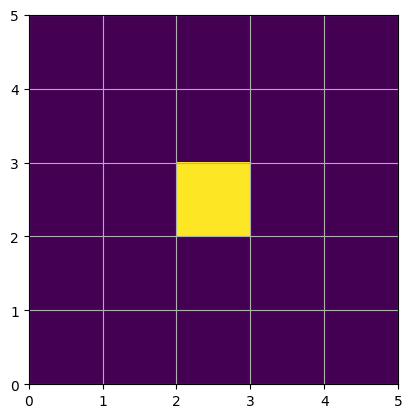


Action taken: Down
Agent Location: (np.int64(1), np.int64(9)), Reward: 0.0, Done: False


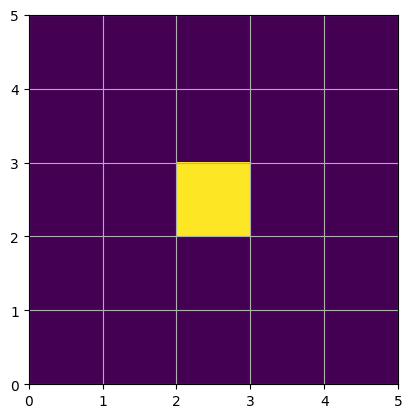


Action taken: Down
Agent Location: (np.int64(2), np.int64(9)), Reward: 0.0, Done: False


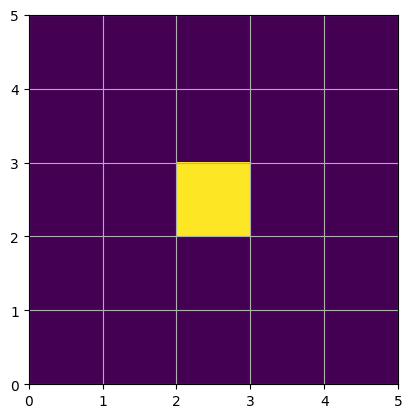

In [10]:
# Create the environment
env = PartiallyObservableGridEnv(size=10, observation_size=5)

# Reset the environment and get initial observation
obs, info = env.reset()
print("Initial Observation:")
env.render()

# Take a few steps (e.g., move right twice)
actions = [1, 1, 2, 2] # Right, Right, Down, Down

for action in actions:
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"\nAction taken: {['Up', 'Right', 'Down', 'Left'][action]}")
    print(f"Agent Location: {info['agent_location']}, Reward: {reward}, Done: {terminated}")
    env.render()
    if terminated:
        print("Goal reached!")
        break

env.close()

